In [1]:
from DataLoading import FacialDetectionDataset,Normalise,Rescale,RandomCrop,ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from visdom import Visdom
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
data_transform = transforms.Compose([Rescale((128)),RandomCrop(96),Normalise(),ToTensor()])

In [3]:
dataset = FacialDetectionDataset(csv_file='data/training_frames_keypoints.csv',root_dir='data/training/',
                                transform=data_transform)

In [4]:
kwargs = {'num_workers' : 4} if torch.cuda.is_available() else {}

In [5]:
batch_size = 10

train_loader = DataLoader(dataset,batch_size = batch_size , shuffle = True , **kwargs)

In [6]:
test_dataset = FacialDetectionDataset(csv_file = 'data/test_frames_keypoints.csv',root_dir = 'data/test/',
                                      transform= data_transform)

In [7]:
test_loader = DataLoader(test_dataset , batch_size= batch_size  , **kwargs)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
sample = dataset[65]
image,keypoints = sample['image'],sample['key_pts']

In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1 ,out_channels= 32 , kernel_size=4 ,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32 ,out_channels= 46 , kernel_size =3 ,stride=1)
        self.conv3 = nn.Conv2d(in_channels=46 ,out_channels = 128 , kernel_size = 2 ,stride =1)
        self.conv4 = nn.Conv2d(in_channels=128 ,out_channels = 256,kernel_size =1 ,stride =1)
        
        self.pool = nn.MaxPool2d(kernel_size=2 , stride =2)
        
        #self.fc1 = nn.Linear(128*6*6,6400)
        self.fc2 = nn.Linear(6400,1000)
        self.fc3 = nn.Linear(1000,500)
        self.fc4 = nn.Linear(500,136)
        
        self.d1 = nn.Dropout(p = 0.5)
        self.d2 = nn.Dropout(p = 0.5)
        self.d3 = nn.Dropout(p = 0.5)
        self.d4 = nn.Dropout(p = 0.5)
        self.d5 = nn.Dropout(p = 0.5)
        self.d6 = nn.Dropout(p = 0.5)
        self.d7 = nn.Dropout(p = 0.5)
        
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        out = self.d1(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        out = self.d2(out)
        
        out = self.conv3(out)
        out = F.relu(out)
        out = self.pool(out)
        out = self.d3(out)
        
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool(out)
        out = self.d4(out)
        
        out = out.view(out.size(0),-1)
        
#         out = self.fc1(out)
#         out = F.elu(out)
#         out = self.d5(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.d6(out)
        
        out = self.fc3(out)
        out = F.relu(out)
        out = self.d7(out)
        
        out = self.fc4(out)
        return out

In [11]:
len(dataset)

3462

In [12]:
3462/10

346.2

In [13]:
346.2*25

8655.0

In [14]:
net = Network()

In [15]:
net = net.to(device)

In [16]:
n_epochs = 1
criterion = nn.MSELoss()

In [17]:
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)

In [18]:
iter = 0
# vis = Visdom()
# vis_window = vis.line(np.array([0]),np.array([0]))
for epoch in range(n_epochs):
    learning_loss =0.0
    for i,sample in enumerate(train_loader):
        image , keypoints = sample['image'],sample['key_pts']
        image = Variable(image.to(device))
        image = image.type(torch.FloatTensor)
        keypoints = Variable(keypoints.to(device)).type(torch.FloatTensor)
        
        optimizer.zero_grad()
        
        outputs = net(image)
        outputs = outputs.reshape(outputs.shape[0],-1,2)
        loss = criterion(outputs,keypoints)
        loss.backward()
        
        optimizer.step()
        learning_loss +=(loss.data.item())
        iter += 1
#         vis.line(np.array([loss.item()]),np.array([iter]),win = vis_window ,update = 'append',opts =dict(xlabel='iterations',
#                                                                                                          ylabel='MSE error',
#                                                                                                          title='epoch loss and accuracy') )
        if i%100 == 0:
            print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, i+1, learning_loss/1000))
            learning_loss = 0.0
            

Epoch: 1, Batch: 1, Avg. Loss: 0.0011868464946746826
Epoch: 1, Batch: 101, Avg. Loss: 1.440201768502593
Epoch: 1, Batch: 201, Avg. Loss: 0.018232221119105815
Epoch: 1, Batch: 301, Avg. Loss: 0.015860977243632078


In [19]:
sample = dataset[90]

In [20]:
image , keypoints = sample['image'] ,sample['key_pts']

In [21]:
image.shape

torch.Size([1, 96, 96])

In [22]:
image = image*255
keypoints = keypoints*50 + 100

In [23]:
image = image.reshape(1,1,96,96)

In [24]:
image = image.type(torch.FloatTensor)

In [25]:
output = net(image)

In [26]:
for param in net.parameters():
    param.requires_grad = False

In [27]:
image = image.numpy()
keypoints = keypoints.numpy()

In [28]:
image= image.reshape(96,96)

In [29]:
output = output*50 + 100

In [30]:
output = output.detach()

In [31]:
output

tensor([[13.7531, 49.0445, 12.0962, 55.2215, 15.1693, 62.1832, 16.9034, 68.3543,
         19.2945, 75.8055, 22.5975, 82.1682, 28.3302, 85.1990, 35.3449, 87.9983,
         43.5826, 90.4514, 51.9583, 86.8394, 56.9676, 83.2455, 62.2169, 79.2293,
         66.1616, 74.4603, 67.5231, 66.8349, 67.2777, 60.5546, 69.7146, 53.2416,
         68.6647, 45.9225, 17.9060, 39.8639, 21.9177, 37.7595, 27.1374, 35.1532,
         29.6119, 36.2948, 34.3697, 37.3613, 47.8303, 35.9583, 50.4562, 35.8388,
         55.4746, 35.3189, 59.8623, 35.5728, 62.0794, 37.5860, 40.7669, 45.1639,
         41.1548, 49.2854, 41.6981, 54.4175, 40.8228, 59.3318, 37.7966, 62.1262,
         39.5966, 61.7686, 41.1755, 63.7784, 43.4150, 62.0322, 46.0904, 61.5692,
         24.3080, 44.9616, 26.7240, 43.5931, 31.2578, 43.8214, 33.4305, 46.5587,
         31.0784, 46.3253, 27.1895, 46.3002, 48.5977, 44.6659, 51.6960, 42.7868,
         53.9745, 42.7071, 56.7044, 43.7373, 53.4999, 45.5981, 50.5798, 45.3195,
         31.9583, 71.5583, 3

In [32]:
output = output.reshape(68,2)

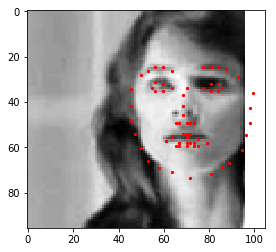

In [34]:
plt.imshow(image,cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
#plt.scatter(output[:,0],output[:,1],s=20,marker='.',c='b')